In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm.notebook import tqdm


from adf.ru import preprocessing
from adf.modelling.dataprep.rus import utils, si, config, md

# TODO: drop warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 500)
plt.rcParams['figure.figsize'] = [15, 5]
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# TODO: DC MAGNIT - rfa (tbt)

In [3]:
# FC_FROM = '2021-06-21'
# FC_TO = 

### Settings

In [4]:
PROJECT_ROOT = '/home/ubuntu/ADF_sdv2.daai.cor.advanced-demand-forecasting'
os.chdir(PROJECT_ROOT)

current_fc_file = r'data/results/outputs/forecast.parquet'
previous_fc_file = r'data/results/outputs/forecast_prev.parquet'

In [5]:
# metric_key = []
granularity = [
    # 'techbillto',
    'client',
    'sku',
    # 'bu',
    'dc'
]
cols =  granularity + ['mad_date', 'ordered', 'discount', 'fc', 'partition']

focus_customer = {
    'DC MAGNIT',
#     'MAGNIT',
    'PYATEROCHKA',
    'LENTA',
    'MARIA-RA',
    'VERNIY',
}

### Readings and preparing

TODO: ordered contains negative values and values like this 9e-07

In [6]:
curr_fc = pd.read_parquet(current_fc_file, columns=cols, )
prev_fc = pd.read_parquet(previous_fc_file, columns=cols, )

In [7]:
for col in ['ordered', 'fc']:
    for df in [curr_fc, prev_fc]:
        df[col] = df[col].round()

In [8]:
curr_fc.head()[cols]

client    sku    dc   mad_date  ordered  discount      fc partition
0  MARIA-RA  21084  5331 2019-03-29    0.000        22  48.000     train
1  MARIA-RA  21084  5331 2019-03-30    0.000        22   0.000     train
2  MARIA-RA  21084  5331 2019-03-31   42.000        22 100.000     train
3  MARIA-RA  21084  5331 2019-04-01   35.000        22  35.000     train
4  MARIA-RA  21084  5331 2019-04-02   67.000        22  51.000     train

In [9]:
curr_fc.rename(columns={'fc': 'curr_fc'}, inplace=True)
prev_fc.rename(columns={'fc': 'prev_fc'}, inplace=True)

In [10]:
partition_df = curr_fc[['mad_date', 'partition']].drop_duplicates().dropna()
partition_from_date = {row.mad_date: row.partition for row in partition_df.itertuples()}

In [11]:
uf = utils.get_ultrafresh_sku(input_path='data/masterdata/Product_MD.csv')
uf_from_sku = {row.sku: row.ultrafresh for row in uf.itertuples()}


### Combine

In [12]:
curr_fc.groupby('partition').agg({'mad_date':[min, max]})

mad_date           
                 min        max
partition                      
fc        2021-06-21 2021-08-01
train     2019-03-25 2021-06-20

In [13]:
prev_fc.groupby('partition').agg({'mad_date':[min, max]})

mad_date           
                 min        max
partition                      
fc        2021-06-21 2021-08-01
train     2019-03-25 2021-06-20

## Поднимем наш прогноз на уровень указанной гранулярности

In [14]:
curr_fc.memory_usage(deep=True).sum() / 1_000_000

2195.346638

In [15]:
for col in granularity + ['partition']:
    curr_fc[col] = curr_fc[col].astype("category")
    prev_fc[col] = prev_fc[col].astype('category')

In [16]:
prev_fc['mad_date'] =  pd.Categorical(prev_fc['mad_date'].astype('category'), 
                                      ordered=True)
curr_fc['mad_date'] =  pd.Categorical(curr_fc['mad_date'].astype('category'), 
                                      ordered=True)

In [17]:
%%time 
agg_rule = {
    'partition': 'first',
    'ordered': 'sum',
    'curr_fc': 'sum',
}

gr_cols = granularity + ['mad_date']


CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10.7 µs


In [18]:
%%time
curr_fc = curr_fc[gr_cols + ['ordered', 'curr_fc']].groupby(gr_cols, as_index=False, observed=True).sum()

CPU times: user 7.67 s, sys: 3.11 s, total: 10.8 s
Wall time: 10.8 s


In [19]:
%%time
prev_fc = prev_fc.groupby(gr_cols, as_index=False, observed=True).prev_fc.sum()

CPU times: user 6.71 s, sys: 2.2 s, total: 8.92 s
Wall time: 8.89 s


In [20]:
%%time
data = curr_fc.merge(prev_fc, on=gr_cols, how='left')

CPU times: user 4.11 s, sys: 1.34 s, total: 5.45 s
Wall time: 5.45 s


In [21]:
# Checking: 
assert data.isna().sum().sum() == 0

In [22]:
data['partition'] = data.mad_date.map(partition_from_date)

CPU times: user 333 ms, sys: 176 ms, total: 509 ms
Wall time: 508 ms


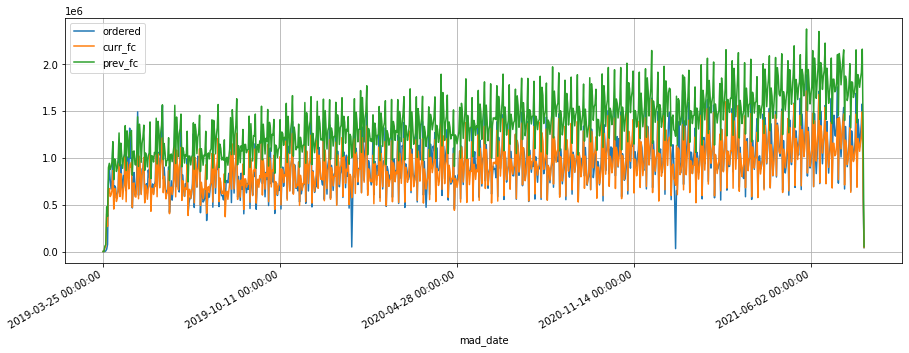

In [23]:
%%time 
data[['mad_date', 'ordered', 'curr_fc', 'prev_fc']].groupby('mad_date').sum().plot(grid=True)

### Посмотрим метрики по фокусным клиентам

In [24]:
data['uf'] = data.sku.map(uf_from_sku)
data.rename(columns={'client':'customer'}, inplace=True)
data = md.add_prod_hier(data)

In [25]:

def get_fa_reports(data, report_lvl, first_fc_col='curr_fc', second_fc_col='prev_fc'):
    
    fc_dates = data[data.partition == 'fc'].mad_date.unique() 
    fc_2w_dates = set(sorted(fc_dates)[:14])
    
    indexer_from_name = {
        'all': data.uf > -1,
        'uf': data.uf == 1,
        '2w': data.mad_date.isin(fc_2w_dates),
        '2w_uf': (data.uf == 1) & data.mad_date.isin(fc_2w_dates),
    }

    tmp = []

    for name_indexer, indexer in indexer_from_name.items():
        print(name_indexer)
        df = data[indexer]

        fa_first = utils.fa_period(df, 
                                 period='st', 
                                 date_column='mad_date', 
                                 fc_col=first_fc_col,
                                 out_gr_cols=report_lvl,
                                 snap_danone=True,
                                )
        fa_first.rename(columns={'AE_w':f'aew_{first_fc_col}', 'Acc': f'fa_{first_fc_col}'}, inplace=True)
        fa_second = utils.fa_period(df, 
                                 period='st', 
                                 date_column='mad_date', 
                                 out_gr_cols=report_lvl,
                                 fc_col=second_fc_col,
                                 snap_danone=True,
                                )
        fa_second.rename(columns={'AE_w':f'aew_{second_fc_col}', 'Acc': f'fa_{second_fc_col}'}, inplace=True)

        metric_df = fa_first.merge(fa_second)
        metric_df['scope'] = name_indexer
        tmp.append(metric_df)
    metrics = pd.concat(tmp)
    
    return metrics


In [26]:
data['mad_date'] = list(data.mad_date.cat._parent) 

In [27]:
%%time 
data['client'] = data['customer'] # OMG!!! Code Master, sorry for this

report_lvl_from_name = {
    'total': ['partition'],
    'chain': ['partition', 'customer'],
    'chain_cat': ['partition', 'customer', 'categ_desc'],
    'lowest': ['partition'] + granularity,
}


report_from_lvl = {}
for lvl_name, report_lvl in report_lvl_from_name.items():
    print(lvl_name)
    metric_report = get_fa_reports(data, report_lvl)
    report_from_lvl[lvl_name] = metric_report
    print()

total
all
uf
2w
2w_uf

chain
all
uf
2w
2w_uf

chain_cat
all
uf
2w
2w_uf

lowest
all
uf
2w
2w_uf

CPU times: user 2min 22s, sys: 29.4 s, total: 2min 51s
Wall time: 2min 50s


### Let analyse reports  

#### Total

In [28]:
current_report = report_from_lvl['total'].query('partition == "fc"')
prev_was_better = current_report[current_report.fa_curr_fc <  current_report.fa_prev_fc]
prev_was_better

Empty DataFrame
Columns: [partition, ordered, curr_fc, aew_curr_fc, fa_curr_fc, prev_fc, aew_prev_fc, fa_prev_fc, scope]
Index: []

#### chain

In [29]:
current_report = report_from_lvl['chain'].query('partition == "fc" and scope == "all"')
prev_was_better = current_report[current_report.fa_curr_fc <  current_report.fa_prev_fc]
prev_was_better

Empty DataFrame
Columns: [partition, customer, ordered, curr_fc, aew_curr_fc, fa_curr_fc, prev_fc, aew_prev_fc, fa_prev_fc, scope]
Index: []

#### chain_cat 

In [30]:
current_report = report_from_lvl['chain_cat'].query('partition == "fc"')
prev_was_better = current_report[current_report.fa_curr_fc <  current_report.fa_prev_fc]
prev_was_better

partition     customer                    categ_desc     ordered  \
23        fc     MARIA-RA           Немолочные продукты  16,805.000   
24        fc     MARIA-RA        Пастеризованное молоко 971,569.000   
26        fc     MARIA-RA         Продукты на сыворотке  57,890.000   
27        fc     MARIA-RA                   Пюре мясное   6,107.000   
32        fc     MARIA-RA        Стерилизованное молоко   4,101.000   
4         fc     MARIA-RA  Кефир, кисломолочные напитки  48,831.000   
5         fc     MARIA-RA        Пастеризованное молоко 971,569.000   
6         fc     MARIA-RA              Питьевые йогурты  26,252.000   
11        fc  PYATEROCHKA                        Творог   5,462.000   
3         fc     MARIA-RA           Немолочные продукты   5,880.000   
4         fc     MARIA-RA        Пастеризованное молоко 275,129.000   
6         fc     MARIA-RA         Продукты на сыворотке  13,634.000   
12        fc     MARIA-RA        Стерилизованное молоко   1,077.000   
16        fc     MARIA-RA        Функциональные напитки  15,405.000   
25        fc  PYATEROCHKA         Продукты на сыворотке 278,194.000   
40        fc    DC MAGNIT      Ароматизированное молоко 159,962.000   
1         fc     MARIA-RA        Пастеризованное молоко 275,129.000   
2         fc     MARIA-RA              Питьевые йогурты   7,153.000   
7         fc  PYATEROCHKA                        Творог   2,605.000   

       curr_fc  aew_curr_fc  fa_curr_fc     prev_fc  aew_prev_fc  fa_prev_fc  \
23  10,121.000    6,629.300       0.606  16,237.000    6,023.600       0.642   
24 783,434.000  282,013.900       0.710 787,993.000  281,058.400       0.711   
26  20,437.000   40,797.000       0.295  28,072.000   35,892.000       0.380   
27   2,654.000    4,095.000       0.329   7,210.000    3,517.000       0.424   
32   2,427.000    1,762.000       0.570   3,943.000    1,296.000       0.684   
4   45,934.000   21,997.400       0.550  52,046.000   21,750.200       0.555   
5  783,434.000  282,013.900       0.710 787,993.000  281,058.400       0.711   
6   17,699.000   10,593.900       0.596  23,829.000    9,632.700       0.633   
11     202.000    5,810.200      -0.064     969.000    5,129.300       0.061   
3    3,446.000    2,481.700       0.578   5,534.000    2,354.900       0.600   
4  216,266.000   85,087.100       0.691 217,823.000   84,870.800       0.692   
6    7,342.000    7,958.000       0.416   9,951.000    6,993.000       0.487   
12     826.000      339.000       0.685   1,344.000      313.000       0.709   
16   9,467.000    9,988.800       0.352  15,218.000    9,920.700       0.356   
25  70,248.000  209,838.000       0.246 157,168.000  154,872.000       0.443   
40  57,691.000  151,056.100       0.056  76,488.000  146,918.200       0.082   
1  216,266.000   85,087.100       0.691 217,823.000   84,870.800       0.692   
2    4,555.000    2,838.600       0.603   6,645.000    2,563.200       0.642   
7       70.000    2,788.500      -0.070     332.000    2,500.300       0.040   

    scope  
23    all  
24    all  
26    all  
27    all  
32    all  
4      uf  
5      uf  
6      uf  
11     uf  
3      2w  
4      2w  
6      2w  
12     2w  
16     2w  
25     2w  
40     2w  
1   2w_uf  
2   2w_uf  
7   2w_uf

#### granularity level

In [31]:
current_report = report_from_lvl['lowest'].query('partition == "fc"')
prev_was_better = current_report[current_report.fa_curr_fc <  current_report.fa_prev_fc]
prev_was_better

partition     client     sku    dc    ordered    curr_fc  aew_curr_fc  \
5          fc  DC MAGNIT   21084  5441  7,480.000  6,285.000    1,730.300   
8          fc  DC MAGNIT   21084  5461  4,444.000  3,997.000      634.700   
12         fc  DC MAGNIT   21084  5501  1,651.000    848.000      883.300   
15         fc  DC MAGNIT   21084  5581  7,703.000  2,430.000    5,800.300   
20         fc  DC MAGNIT   21139  5441  6,253.000  4,881.000    1,810.600   
..        ...        ...     ...   ...        ...        ...          ...   
660        fc      LENTA   54983  5454 34,215.000 31,145.000    6,954.000   
664        fc      LENTA   54983  5342  6,020.000  3,769.000    2,773.000   
667        fc      LENTA   54983  5312  8,010.000  7,697.000    2,657.000   
740        fc      LENTA  113736  5322  1,942.000  1,340.000      487.200   
947        fc      LENTA  160046  5402  7,437.000  4,691.000    2,710.400   

     fa_curr_fc    prev_fc  aew_prev_fc  fa_prev_fc  scope  
5         0.769  7,814.000    1,377.200       0.816    all  
8         0.857  4,757.000      441.100       0.901    all  
12        0.465  1,609.000      508.200       0.692    all  
15        0.247  3,981.000    4,094.200       0.468    all  
20        0.710  6,415.000    1,056.000       0.831    all  
..          ...        ...          ...         ...    ...  
660       0.797 32,187.000    6,654.000       0.806  2w_uf  
664       0.539  4,287.000    2,551.000       0.576  2w_uf  
667       0.668  8,489.000    2,655.000       0.669  2w_uf  
740       0.749  1,596.000      442.400       0.772  2w_uf  
947       0.636  5,468.000    2,673.300       0.641  2w_uf  

[2326 rows x 12 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe552672d90>,
      dtype=object)

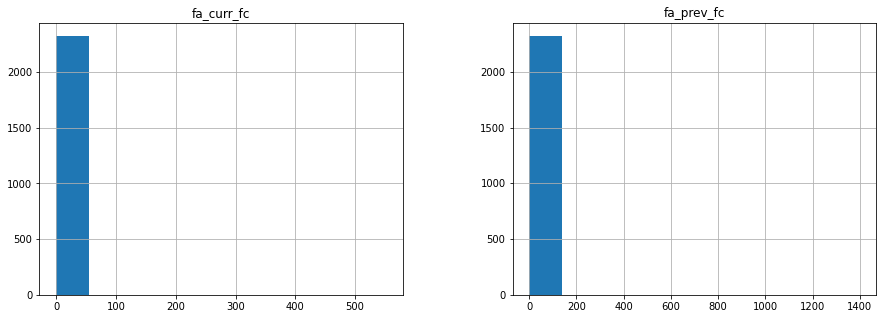

In [32]:
prev_was_better[['fa_curr_fc', 'fa_prev_fc']].hist()

#### Anomaly FAs 

In [33]:
current_report = report_from_lvl['lowest'].query('partition == "fc"')
prev_was_better = current_report[current_report.fa_curr_fc <  current_report.fa_prev_fc]
anomaly_fas = prev_was_better[(prev_was_better.fa_curr_fc > 1 )
                                |(prev_was_better.fa_prev_fc > 1 )
                                | (prev_was_better.fa_curr_fc < 0 )
                                |(prev_was_better.fa_prev_fc < 0 )
                               ]
anomaly_fas

partition       client     sku    dc    ordered   curr_fc  aew_curr_fc  \
28          fc    DC MAGNIT   21139  5581  5,624.000     0.000    6,186.400   
59          fc    DC MAGNIT   30269  5581  4,859.000     0.000    5,344.900   
437         fc    DC MAGNIT   82408  5581  2,660.000     0.000    2,926.000   
1192        fc    DC MAGNIT  133153  5501  1,627.000   294.000    1,732.900   
1194        fc    DC MAGNIT  133180  5401  1,475.000    90.000    1,669.200   
1195        fc    DC MAGNIT  133180  5392    923.000    37.000    1,063.200   
1218        fc    DC MAGNIT  134901  5461    589.000   141.000      606.000   
1489        fc    DC MAGNIT  153705  5411  1,820.000   898.000    1,832.600   
1663        fc    DC MAGNIT  159214  5402  3,087.000   113.000    3,271.400   
1665        fc    DC MAGNIT  159214  5441  1,185.000    32.000    1,272.700   
1667        fc    DC MAGNIT  159214  5454  6,639.000   141.000    7,150.000   
1668        fc    DC MAGNIT  159214  5461  2,603.000    70.000    2,786.300   
1670        fc    DC MAGNIT  159214  5351  8,912.000   500.000    9,253.200   
1671        fc    DC MAGNIT  159214  5342  4,216.000   126.000    4,499.000   
1673        fc    DC MAGNIT  159214  5411  3,680.000   114.000    3,922.600   
1725        fc    DC MAGNIT  159220  5454 18,232.000 1,205.000   18,729.700   
1731        fc    DC MAGNIT  159222  5322  3,659.000    58.000    3,961.100   
1735        fc    DC MAGNIT  159222  5441  7,498.000   343.000    7,870.500   
1737        fc    DC MAGNIT  159222  5454 10,967.000 1,938.000   12,373.900   
1738        fc    DC MAGNIT  159222  5461  3,520.000   294.000    3,550.800   
1739        fc    DC MAGNIT  159222  5381 18,642.000   939.000   19,543.700   
1740        fc    DC MAGNIT  159222  5351 10,885.000   689.000   11,224.400   
1743        fc    DC MAGNIT  159222  5411  9,285.000   820.000   10,431.300   
1894        fc    DC MAGNIT  161356  5401    715.000   100.000      799.500   
1900        fc    DC MAGNIT  161356  5461    928.000   124.000    1,045.200   
1901        fc    DC MAGNIT  161356  5381  2,577.000   329.000    2,922.400   
2189        fc     MARIA-RA  151362  5331    861.000   103.000      909.600   
2190        fc     MARIA-RA  151362  5322  3,337.000   369.000    3,561.600   
2191        fc     MARIA-RA  151363  5331    941.000   103.000    1,005.600   
2192        fc     MARIA-RA  151363  5322  3,512.000   369.000    3,771.600   
2234        fc     MARIA-RA  159171  5322  8,650.000   708.000    8,736.200   
2907        fc  PYATEROCHKA   90022  5331  3,512.000     6.000    3,861.000   
2908        fc  PYATEROCHKA   90022  5322  6,764.000    30.000    7,429.400   
3029        fc  PYATEROCHKA   98408  5441  2,119.000    12.000    2,317.700   
3546        fc  PYATEROCHKA  108175  5381     -3.000 1,105.000    1,108.000   
3551        fc  PYATEROCHKA  108705  5454  5,462.000   202.000    5,810.200   
5054        fc  PYATEROCHKA  159224  5381     -4.000 2,004.000    2,208.800   
5274        fc  PYATEROCHKA  161355  5362     -9.000    84.000       93.000   
9044        fc        LENTA  159217  5322  1,805.000 1,180.000    1,831.500   
9065        fc        LENTA  159218  5322  1,635.000 1,024.000    1,906.300   
9086        fc        LENTA  159219  5322  1,867.000 1,515.000    2,378.200   
9107        fc        LENTA  159220  5322  1,881.000 1,486.000    2,352.900   
9128        fc        LENTA  159221  5322  1,370.000   992.000    1,740.200   
9149        fc        LENTA  159222  5322  1,581.000 1,115.000    1,724.800   
9191        fc        LENTA  159224  5322  1,199.000   804.000    1,389.300   
105         fc    DC MAGNIT  134901  5461    589.000   141.000      606.000   
380         fc  PYATEROCHKA  108705  5454  5,462.000   202.000    5,810.200   
160         fc     MARIA-RA  151362  5331    460.000    42.000      501.600   
161         fc     MARIA-RA  151362  5322  1,659.000   126.000    1,839.600   
162         fc     MARIA-RA  151363  5331    508.000   

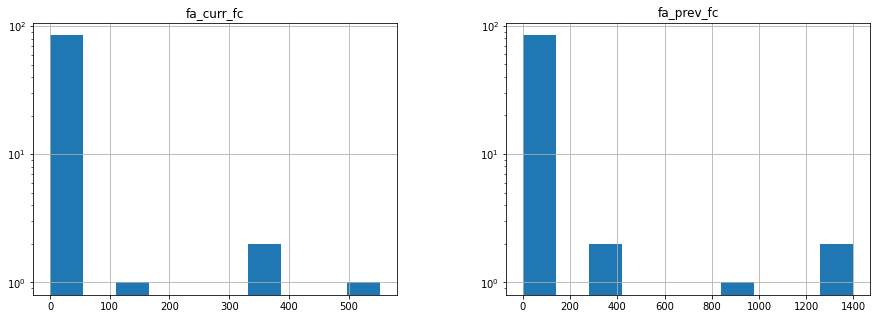

In [34]:
axs = anomaly_fas[['fa_curr_fc', 'fa_prev_fc']].hist()
for ax in axs.flatten(): 
    ax.set_yscale('log')

# Save reports in excel

In [35]:

from pathlib import Path
Path("data/results/reports/").mkdir(parents=True, exist_ok=True)

report_file = r'data/results/reports/curr_vs_prev_report.xlsx'
writer = pd.ExcelWriter(report_file, engine = 'xlsxwriter')
for scope, report in report_from_lvl.items():
    report.query('partition == "fc"').to_excel(writer, sheet_name=scope)
writer.save()
writer.close()